# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.23.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

<span style="font-family:Verdana; color: green;">ANSWER: </span>

<span style="font-family:Verdana; color: green;">The mathematical formulation of 2-D convolution is given by: $$y_{ij} = \sum_{m=-\infty}^{\infty} \sum_{n=-\infty}^{\infty} h_{m,n} x_{i-m,j-n}$$ where, $x$ represents the input image matrix to be convolved with the kernel matrix $h$ to result in a new matrix $y$, representing the output image. Here, the indices $i$ and $j$ are concerned with the image matrices while those of $m$ and $n$ deal with that of the kernel. If the size of the kernel involved in convolution is 3 √ó 3, then the indices $m$ and $n$ range from -1 to 1.</span>

<span style="font-family:Verdana; color: green;"> In the cell below, we have implemented function convolution(). This function takes a image and a kernel as parameters. This function recomputes each pixel in the image as the weighted average by computing the linear combination of the original value and the values around with that of the kernel values as we slide the kernel on the image. To demonstrate the effect of the kernel on the image we have run the convolution on the first 3 images in the dataset and have displayed it below.</span>

<span style="font-family:Verdana; color: green;"> Finally, in function Q1() we applied the filters in 2(A), 2(B), 2(C), and 2(D) as described above. </span>

In [4]:
def convolution(img, kernel):
    # get image size
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    # get kernel size
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]
    
    # pad image with zeros
    padded_img = np.pad(img, 
                        pad_width=((kernel_h // 2, kernel_h // 2),(kernel_w // 2, kernel_w // 2)), 
                        mode='constant', constant_values=0).astype(np.float32)
    
    # find midpoint of the kernel
    ph = kernel_h//2
    pw = kernel_w//2
    
    #Convolve the image with the kernel
    img_new = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)
    for i in range(ph, img_h+ph):
        for j in range(pw, img_h+pw):
            img_new[i-ph][j-pw] = (kernel.flatten() * padded_img[i-ph:i+ph+1, j-pw:j+pw+1].flatten()).sum()

    return img_new


cnt = 0

#initialize the kernel with the gaussian
kernel = np.array([[0.07511361, 0.1238414 , 0.07511361], [0.1238414 , 0.20417996, 0.1238414 ], [0.07511361, 0.1238414 , 0.07511361]])
#initialize the plot
fig, ax = plt.subplots(2, 3, sharey=True)

#convolve image 0 and show
img = mini_train_data[cnt].reshape(28, 28)
ax[0,cnt].imshow(img, cmap='gray')
img = convolution(mini_train_data[cnt].reshape(28, 28), kernel)
ax[1,cnt].imshow(img, cmap='gray')
cnt += 1

#convolve image 1 and show
img = mini_train_data[cnt].reshape(28, 28)
ax[0,cnt].imshow(img, cmap='gray')
img = convolution(mini_train_data[cnt].reshape(28, 28), kernel)
ax[1,cnt].imshow(img, cmap='gray')
cnt += 1
 
#convolve image 2 and show
img = mini_train_data[cnt].reshape(28, 28)
ax[0,cnt].imshow(img, cmap='gray')
img = convolution(mini_train_data[cnt].reshape(28, 28), kernel)
ax[1,cnt].imshow(img, cmap='gray')
cnt += 1
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);



def Q1():
    ### STUDENT START ###
    model = KNeighborsClassifier(n_neighbors=1)
    
    #ModelA: Do not use the filter
    model.fit(mini_train_data, mini_train_labels)
    pred = model.predict(dev_data)
    acc = sum(pred == dev_labels)/len(dev_labels)
    print("Accuracy of Model A: " + str(acc))
    
    #Model B: Filter the training data but not the dev data
    mini_train_data_filtered  = [convolution(td.reshape(28, 28), kernel).flatten() for td in mini_train_data]
    model.fit(mini_train_data_filtered, mini_train_labels)
    pred = model.predict(dev_data)
    acc = sum(pred == dev_labels)/len(dev_labels)
    print("Accuracy of Model B: " + str(acc))
 
    #FModel C:Filter the dev data but not the training data
    model.fit(mini_train_data, mini_train_labels)
    dev_data_filtered  = [convolution(dd.reshape(28, 28), kernel).flatten() for dd in dev_data]
    pred = model.predict(dev_data_filtered)
    acc = sum(pred == dev_labels)/len(dev_labels)
    print("Accuracy of Model C: " + str(acc))
    
    #Model D:Filter both training data and dev data
    mini_train_data_filtered  = [convolution(td.reshape(28, 28), kernel).flatten() for td in mini_train_data]
    model.fit(mini_train_data_filtered, mini_train_labels)
    dev_data_filtered  = [convolution(dd.reshape(28, 28), kernel).flatten() for dd in dev_data]
    pred = model.predict(dev_data_filtered)
    acc = sum(pred == dev_labels)/len(dev_labels)
    print("Accuracy of Model D: " + str(acc))
    ### STUDENT END ###

Q1()

Accuracy of Model A: 0.884
Accuracy of Model B: 0.906
Accuracy of Model C: 0.868
Accuracy of Model D: 0.901


<span style="font-family:Verdana; color: green;"> As we see in the output above, we have the displayed the accuracies of four models and as expected in question 1.4 the accuracies of the model B and D are 0.906 and 0.901 respectively are above 0.9. </span>

### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



<span style="font-family:Verdana; color: green;">ANSWER: </span>

<span style="font-family:Verdana; color: green;"> In the cell below, we have two implementations (i) binarize, and (ii) ternarize. Function binarize takes in a threshold and takes a set of images. And for each pixel in those images binarize() replaces it with either 1 or 0 depending on that pixel value is above or below the threshold value. Similarly, the ternarize takes in two thresholds low and high. Function ternaize replaces each pixel with either 0, 1, or 2 depending on if the pixel value. The function will replace the pixel with 0 if it is less than or equal to **low**, 1 if it is above **low** and less than or equal to **high** else 2.</span>

<span style="font-family:Verdana; color: green;"> In the first part of Q2(), we binarize() the train_data and created a BernoulliNB model with the binarized data and measured the accuracy with the test data. Similarly, we ternarize the train data and created a MultinomialNB model with the ternairized data and measured the accuracy with the test data. </span>

<span style="font-family:Verdana; color: green;"> **To our surprize, BernoulliNB performed slightly better than MultinomialNB.** While it is difficult to sum up their performances  of these two models in general, MultinomialNB is in a sense a slightly more complex model than BernoulliNB. For the mnist data in hand, BernoulliNB deals with 1 or 0 values per pixel and uses lesser information to train the model. For example, BernoulliNB uses the probablity at each pixel in the image (28x28). For e.g. how many times a pixel is either 0 or 1 for a particular class as opposed to the multinomialNB how many times a pixel takes a value 0, 1, or 2 for a given class. Hence due to a principle of parsimony a simple model is less prone to overfitting than a complex model and perhaps is the reason why BernoulliNB model performs better than the MulitnomialNB.</span>

In [19]:
# Solution with binarization by explicit binarize function
# binarize_example():
#   Turn all pixels below 0.5 (or threshold) -> 0, greater -> 1
def binarize_example(example, threshold = 0.1):
    binarized = [ 1 if value > threshold else 0 for value in example ]
    return binarized
    
# binarize_examples():
#   Apply binarization to a set of example
def binarize_examples(examples, threshold = 0.1):
    binarized = [ binarize_example(example, threshold) for example in examples ]
    return binarized

# ternarize_example():
#   Turn all pixels below 1/3 (or threshold) -> 0, 1/3 through 2/3 -> 1, greater -> 2
def ternarize_example(example, threshold_low = 0.1, threshold_high = 0.9):
    ternarized = [ 
        0 if value < threshold_low else 1 if value < threshold_high else 2
        for value in example
    ]
    return ternarized

# ternarize_examples():
#   Apply ternarization to a set of example
def ternarize_examples(examples, threshold_low = 0.1, threshold_high = 0.9):
    ternarized = [ 
        ternarize_example(example, threshold_low, threshold_high) 
        for example in examples 
    ]
    return ternarized

def Q2():
    ### STUDENT START ###
    binarized_train_data = binarize_examples(train_data)
    
    #Create Bernoulli Model
    binary_naive_bayes = BernoulliNB()
    binary_naive_bayes.fit(binarized_train_data, train_labels)

    #Evaluate the model with dev data
    binarized_dev_data = binarize_examples(dev_data)
    binary_naive_bayes_predicted = binary_naive_bayes.predict(binarized_dev_data)
    print('Bernoulli model accuracy: ', sum(binary_naive_bayes_predicted == dev_labels)/len(dev_data))

    ternarized_train_data = ternarize_examples(train_data)
    
    #Create MultinomialNB Model
    ternary_naive_bayes = MultinomialNB()
    ternary_naive_bayes.fit(ternarized_train_data, train_labels)

    #Evaluate the model with dev data
    ternarized_dev_data = ternarize_examples(dev_data)
    ternary_naive_bayes_predicted = ternary_naive_bayes.predict(ternarized_dev_data)
    print('Multinomial model accuracy: ', sum(ternary_naive_bayes_predicted == dev_labels)/len(dev_data))
    ### STUDENT END ###

Q2()

Bernoulli model accuracy:  0.829
Multinomial model accuracy:  0.818


### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



<span style="font-family:Verdana; color: green;">ANSWER: </span>

<span style="font-family:Verdana; color: green;"> In the cell below, we have implemented Q3(). In Q3(), We have leveraged the binarize() function implemented in our previous question by passing a threshold value of 0.0. We binarized the mini train. We have used the GridSearchCV defined in model_selection module of sklearn to do the grid search. We did the grid search with different alphas and evaluated the performance by setting cross-validation to 5-fold.</span>

In [6]:
def Q3(alphas):
    ### STUDENT START ###
    #binaried the mini train at threshold 0.0
    binarized_train_data = binarize_examples(mini_train_data, threshold = 0.0)
    #perform GridSearch with 5-fold cross-validation
    clf = GridSearchCV(BernoulliNB(), param_grid=alphas, scoring='accuracy', cv=5, iid=False)
    # running the grid search
    clf.fit(binarized_train_data, mini_train_labels) 
    print(clf.best_params_)
    print(clf.best_score_)
    print(clf.scorer_)
    print(clf.best_index_)
    ### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)

{'alpha': 0.001}
0.825
make_scorer(accuracy_score)
2


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [7]:
binarized_train_data = binarize_examples(mini_train_data, threshold = 0.0)
bnb = BernoulliNB(alpha=0.0)
bnb.fit(binarized_train_data, mini_train_labels)
bnb.score(dev_data, dev_labels)

/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


0.816

<span style="font-family:Verdana; color: green;">Answer for part 2:</span>

<span style="font-family:Verdana; color: green;">As noted above the best performing alpha was 0.001 and the accuracy at that alpha came out to be at 0.825 which is slightly better than when the alpha was set to 0.0.<span>

<span style="font-family:Verdana; color: green;">Yes, this was our expectation as well. In the absence of alpha (i.e. when the alpha is set 0.0) or if the value is too small (e.g. 1.0e-10) due to numeric errors the model accuracy is compromised.<span>

### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

<span style="font-family:Verdana; color: green;">ANSWER:</span>

<span style="font-family:Verdana; color: green;">In Q4() below, We first trained the GaussianNB model with the mini_train set. With default hyperparameters, the model performed with the accuracy of 0.593. Then we did grid search with different var smoothing values (e.g logspace(0, -9)) the model seemed to have performed better with accuracy of 0.799.<span>
    
<span style="font-family:Verdana; color: green;">Gaussian filter weights the signal heavily at mean and the weights fall off exponentially as it moves away from mean. In the context of Naive Bayes, each feature is assummed to be a Gaussian distribution. The fall off of the gaussian can be adjusted using the var_smoothing parameter. The variable, var_smoothing, artificially adds a user-defined value to the distribution's variance. We have experimented the var_smoothing with values from a logspace between (0 and -9). Apparently, the grid search found that the var_smoothing at $log_e(0.035112) = -1.45$ was performing the best.<span>

In [17]:
def Q4():
    ### STUDENT END ###
    # default GaussianNB model and printing the performance score
    gnb = GaussianNB()
    gnb.fit(mini_train_data, mini_train_labels)
    print("Score before diagnosis: ",gnb.score(dev_data, dev_labels))
    
    #we are doing grid search with for varying var_smooting values
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    gs_NB = GridSearchCV(estimator=GaussianNB(), 
                         param_grid=params_NB,
                         cv=5,   # use any cross validation technique 
                         verbose=1,
                         scoring='accuracy') 
    
    #printing the scores to evaluate the performance
    gs_NB.fit(mini_train_data, mini_train_labels)
    print(gs_NB.best_params_)
    print(gs_NB.best_score_)
    print(gs_NB.scorer_)
    print(gs_NB.best_index_)
    ### STUDENT END ###

Q4()

Score before diagnosis:  0.593
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'var_smoothing': 0.03511191734215131}
0.799
make_scorer(accuracy_score)
16


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.2s finished


### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



<span style="font-family:Verdana; color: green;">ANSWER:</span>

<span style="font-family:Verdana; color: green;">In cell below, Function Q5() creats a BernoulliNB model with alpha=0.001. We have fit the model with the binarized mini_train data. We generated the log probability of each pixel for class using the feature_log_prob_ and we converted the log probabilities to base probabilities. And we generated the pixel output 0 or 1 by comparing the randomly generated number with the estimated probability. The generated images look bit grainier than the original mini train data images.<span>
    
<span style="font-family:Verdana; color: green;">When we approximate the pixel to be either 0 or 1 in our binarize function we loose information. And BernoulliNB then uses the mean at each pixel in the image (28x28). For e.g. how many times a pixel is 0 or 1 for a particular class. The above information loss attributed to our binarize leads to this grainy images.<span>

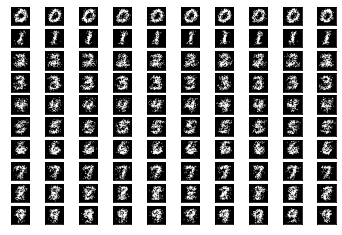

In [16]:
def Q5():
    # We create model and get feature probs
    binarized_train_data = binarize_examples(mini_train_data)
    bnb = BernoulliNB(alpha=0.001)
    bnb.fit(binarized_train_data, mini_train_labels)
    prob = np.exp(bnb.feature_log_prob_)

    # rendering 10 random images generated
    fig, ax = plt.subplots(10, 10)
    for i in range(10):
        for j in range(10):
            #we draw a random number from a uniform distribution and compare it against the feature prob
            ax[i, j].imshow((np.random.uniform(0, 1, 28*28) < prob[i]).astype(int).reshape(28, 28), cmap='gray')

    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    
Q5()

<span style="font-family:Verdana; color: green;">In the following cell we have computed the probabilties **from scratch to compare the output with the above approach**. we have implemented a function NaiveBayes() that iterates through the provided train data to compute the mean for each pixel for each class(e.g. labels {0, 1, ..9}). We then again iterate through these generated means for each label and generate 10 random images (using np.random.uniform) for each label and have displayed those images. In Q5(), we invoked the NaiveBayes with a binarized train data. <span>
    
<span style="font-family:Verdana; color: green;">Output is presented here for comparision.<span>

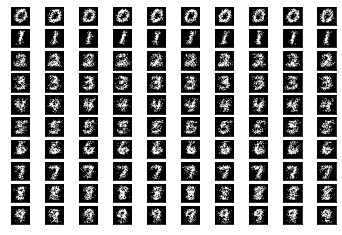

In [10]:
fig, ax = plt.subplots(10, 10)

def NaiveBayes(X_train, y_train, X_test):
    stats = dict()
    label_train = set(y_train)
    
    #we calculate feature average and treat it as the prob
    for c in label_train:
        current_X = X_train[y_train==c]
        stats[c] = {
            'mean':current_X.mean(axis=0), # Mean for each digit.
        }

    
    V = dict()
    # Calculating the probabilities.
    for c, g in stats.items():
        mean = g['mean']
        V[c] = []
        for i in range(10):
            #we draw a random number from a uniform distribution and compare it against the feature prob
            V[c].append((np.random.uniform(0, 1, 28*28) <= mean).astype(int))
            
    
    
    for c,g in stats.items():
        for i in range(10):
            #render the image 
            ax[int(c), i].imshow(V[c][i].reshape(28, 28), cmap='gray')
            continue
    return

def Q5_scratch(num_examples):
    ### STUDENT START ###
    binarized_train_data = binarize_examples(mini_train_data)
    NaiveBayes(np.array(binarized_train_data), mini_train_labels, dev_data)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    ### STUDENT END ###

Q5_scratch(10)

### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



<span style="font-family:Verdana; color: green;">ANSWER:</span>

<span style="font-family:Verdana; color: green;">We discretize our model predictions into $ùëÄ$ interval bins, and calculate the average actual accuracy and predicted probability for each bin. By doing this samples that have similar predicted score will fall into the same bin.<span>
    
<span style="font-family:Verdana; color: green;">Let the bins are represented by a sequence ${I_1, I_2, ...., I_n}$ and $ùêµ_m$ be the set of samples whose predicted probability falls into interval  $ùêº_ùëö=(\frac{ùëö‚àí1}{ùëÄ},\frac{ùëö}{ùëÄ}]$ and $ |ùêµ_ùëö| = \sum \limits_{ùëñ \in ùêµ_m}y_i$.  The Acutal Accuracy for $ùêµ_ùëö$ can be computed by the following equation: $$ AA(ùêµ_ùëö) = \frac{\sum \limits_{ùëñ \in ùêµ_m}\hat{y_i} = y_i}{|B_m|} $$ Where $y_i$ is the true class label and $\hat{y_i}$ is the predicted class label for sample $i$ (assuming in the binary classification setting 1 denotes a positive class and 0 otherwise). Similarly, The Model Accuracy for $ùêµ_ùëö$  is defined by the following equation : $$ MA(ùêµ_ùëö) = \frac{\sum \limits_{ùëñ \in ùêµ_m}\hat{p_ùëñ}}{|B_m|}$$ Where $\hat{p_i}$ is the predicted probability for sample $i$. <span>

<span style="font-family:Verdana; color: green;"> The following function Q6() takes in the following arguments buckets, binwise correct count, and binwise probability sum. The driver code computes the binwise paremeters and passes it to the Q6 function. And the plot-1 shows the accuracy curve plotted against model accuracy and plot-2 shows the accuracy in each bin (e.g. bin-0, bin-1, etc.).<span>

Overall accuracy of the model:  0.823
Binwise Total [ 31  67  59  46  62  33  43  19 640]
Binwise Model Acc. [0.72810262 0.97703774 0.99977507 0.9999976  0.99999997 1.
 1.         1.         1.        ]
Binwise Actual Acc. [0.35483871 0.43283582 0.45762712 0.65217391 0.77419355 0.78787879
 0.79069767 0.84210526 0.940625  ]


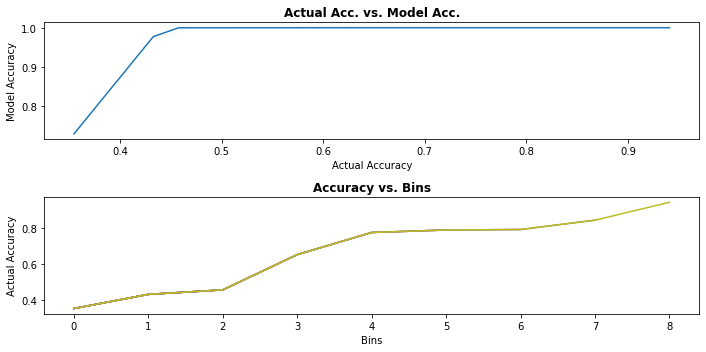

In [15]:
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

#Driver Code - We have created a BernoulliNB model using binarized mini train
binarized_train_data = binarize_examples(mini_train_data, threshold = 0.0)
bnb = BernoulliNB(alpha=0.001)
bnb.fit(binarized_train_data, mini_train_labels)

#We tested the model using the dev set
binarized_test_data = binarize_examples(test_data, threshold = 0.0)
probs = bnb.predict_proba(dev_data)
preds = bnb.predict(dev_data)
print("Overall accuracy of the model: ", bnb.score(dev_data, dev_labels))

#we lookup the probability of the predicted label
y_probs = np.max(probs, axis=1)
#we compute the corrects
y_corrects = ((dev_labels == preds)).astype(np.int)

#we compute the binids
binids = np.digitize(y_probs, buckets)-1
#we compute the prob sum for each bin
bin_sum = np.bincount(binids, weights=y_probs, minlength=len(buckets))
#we compute the correct counts for each bin
bin_correct = np.bincount(binids, weights=y_corrects, minlength=len(buckets))
#we compute the total samples per bin
bin_total = np.bincount(binids, minlength=len(buckets))

# we compute the model and acutal accuracies
# luckily there are no zero elements
print("Binwise Total", bin_total)
print("Binwise Model Acc.", bin_sum/bin_total)
print("Binwise Actual Acc.", bin_correct/bin_total)


def Q6(corrects, total, sums):
    ### STUDENT BEGIN ##
    x = []
    y = []
    
    #Create a plot with two axes
    fig, ax = plt.subplots(2, 1, figsize=(10,5))
    ax[0].set_xlabel("Actual Accuracy")
    ax[0].set_ylabel("Model Accuracy")
    ax[0].set_title('Actual Acc. vs. Model Acc.',fontweight ="bold")
    
    #run through the data to compute model and actual accurcies
    #and plot it in the first axis
    for c, s, tot in zip(corrects, sums, total):
        if tot != 0:
            x.append(c/tot)
            y.append(s/tot)
    ax[0].plot(x, y)
    
    x.clear()
    y.clear()
    #run through data to calculate acutal accuracy per bin
    for i, tot in enumerate(bin_total):
        if tot != 0:
                x.append(i)
                y.append(corrects[i]/tot)
        ax[1].plot(x, y)
    ax[1].set_ylabel("Actual Accuracy")
    ax[1].set_xlabel("Bins")
    ax[1].set_title('Accuracy vs. Bins',fontweight ="bold")
    plt.tight_layout()
    ### STUDENT END ##
    
Q6(bin_correct, bin_total, bin_sum)

<span style="font-family:Verdana; color: green;"> From plot-1 we can note that the model claims its accuracy is over 0.97 from bin-1 onwards but the acutal accuracy touches .94 only in bin-8. Model consistently under performs to what it claims it will perform. So clearly the model is **NOT A STRONGLY CALIBRATED** model. From looking at values of binwise model accuracy and binwise actual accuracy we can see a positive correlation. So we can say that the above model is **NOT A POORLY CALIBRATED** either. So, the above model can be called a  **WEAKLY CALIBRATED**.<span>

### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

<span style="font-family:Verdana; color: green;">ANSWER:</span>

<span style="font-family:Verdana; color: green;">In cell below, we have implemented a function pool2d() that will generate rolling maximum or rolling average values of the sub-region depending on the mode argument (max or avg). Also, pool2d also accepts a tuple pool_size as an argument. In Q7(), we iterated with different pool sizes and tried both max and avg modes. And have presented the results for avg mode below. To demonstrate the impact of pool2d on the digit image, we picked a random image and passed it to pool2d and rendered the image for review.<span>
    
<span style="font-family:Verdana; color: green;">In the following experiment, we have modeled a BernoulliNB using the mini train set after applying pool2d on the images.<span>

Bernoulli model accuracy for pool size  2 :  0.814
Bernoulli model accuracy for pool size  3 :  0.795
Bernoulli model accuracy for pool size  4 :  0.759
Bernoulli model accuracy for pool size  5 :  0.71


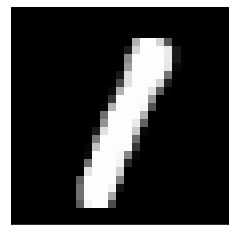

In [21]:
def pool2d(X, pool_size, mode='max'):
    #get pool size
    p_h, p_w = pool_size
    
    #initialize o/p array
    Y = np.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    
    #iterate through signal elements 
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            # for each signal element find its neighbors and 
            # compute max or average depending upon the mode
            if mode == 'max':
                Y[i, j] = X[i:i + p_h, j:j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i:i + p_h, j:j + p_w].mean()
    return Y

# iterate through images to compute the maxpool for each image
def maxpool_examples(examples, n=2, threshold = 0.1, mode='max'):
    # we binarize each image with the provided threshold 
    if mode == 'max':
        binarized = [ pool2d(np.array(binarize_example(example.reshape(-1), threshold)).reshape(28, 28), (n, n)).reshape(-1) for example in examples ]
    else:
        binarized = [ pool2d(np.array(binarize_example(example.reshape(-1), threshold)).reshape(28, 28), (n, n), mode="avg").reshape(-1) for example in examples ]
    return binarized

 

img = mini_train_data[10].reshape(28, 28)
img1 = pool2d(img, (2, 2))
plt.imshow(img1, cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
def Q7():
    ### STUDENT START ###
    for ps in [2, 3, 4, 5]:
        binarized_train_data = maxpool_examples(mini_train_data, n=ps, threshold=0.0)
        binary_naive_bayes = BernoulliNB(alpha=0.001)
        binary_naive_bayes.fit(binarized_train_data, mini_train_labels)
        binarized_dev_data = maxpool_examples(dev_data, n=ps, threshold=0.0)
        print('Bernoulli model accuracy for pool size ',str(ps), ': ', binary_naive_bayes.score(binarized_dev_data, dev_labels))
    ### STUDENT END ###

Q7()

<span style="font-family:Verdana; color: green;">We have presented the accurcy for each poolsize. The best performance we achieved was for the poolsize (3,3).<span>